Torch device: NVIDIA GeForce GTX 1660 Ti


/tmp/ipykernel_270278/1037315731.py:76: RuntimeWarning: overflow encountered in scalar subtract
  dists+= [np.sqrt((a-c)**2+(b-d)**2)]


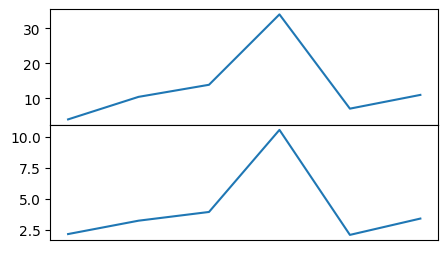

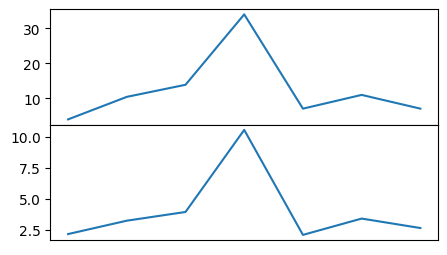

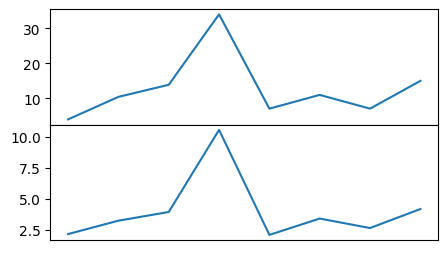

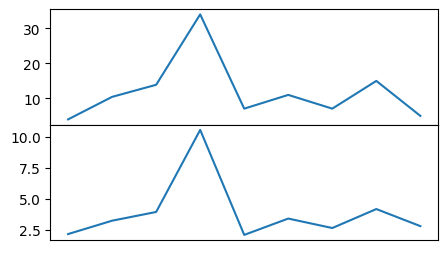

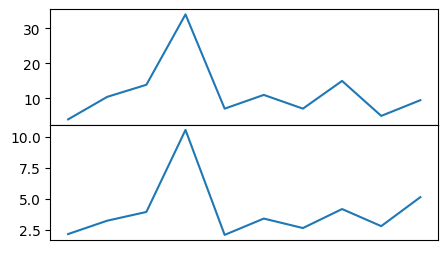

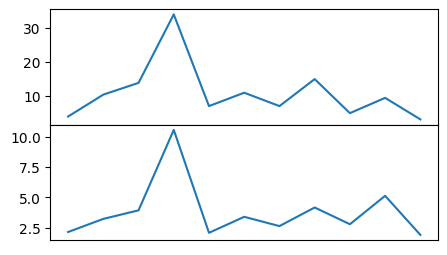

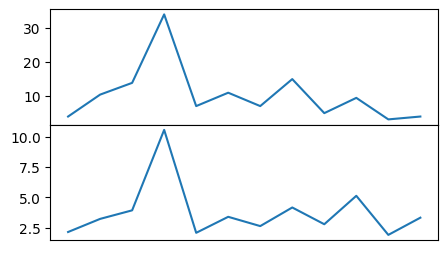

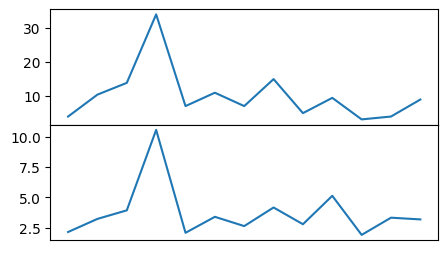

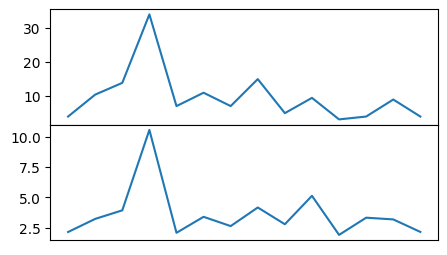

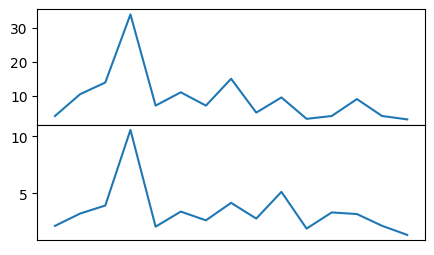

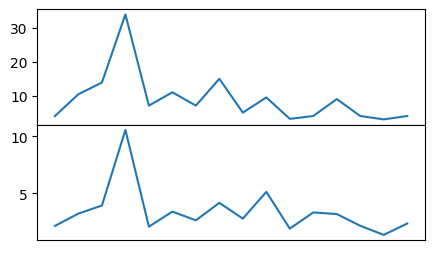

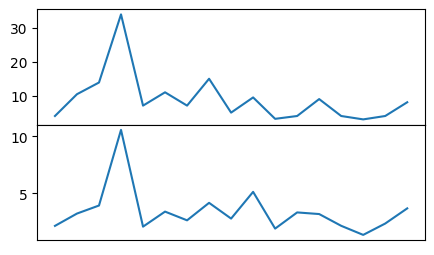

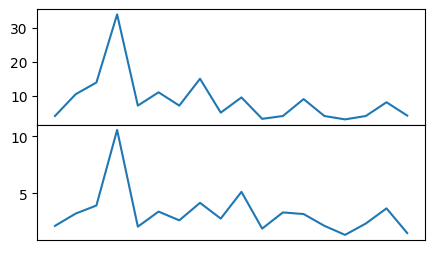

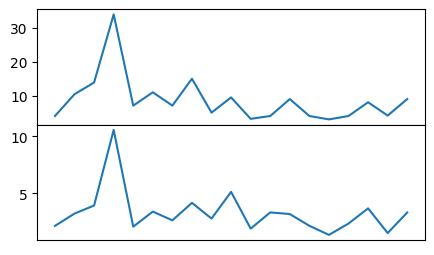

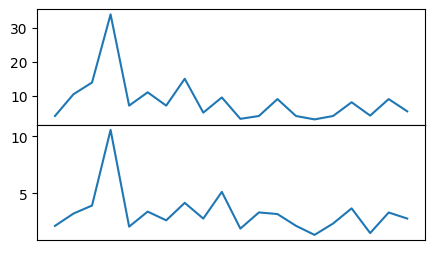

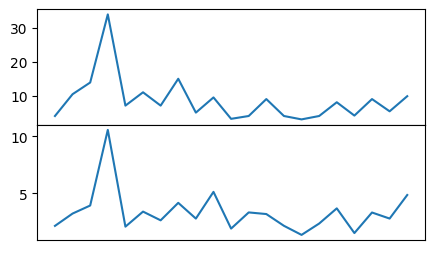

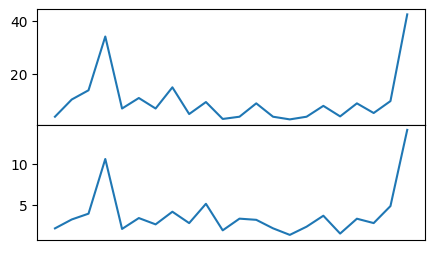

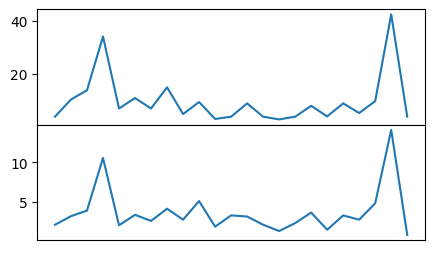

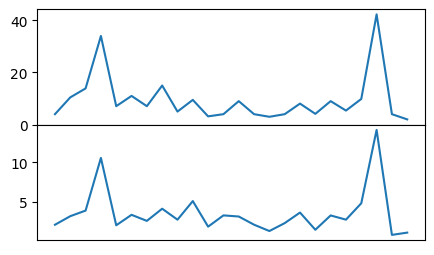

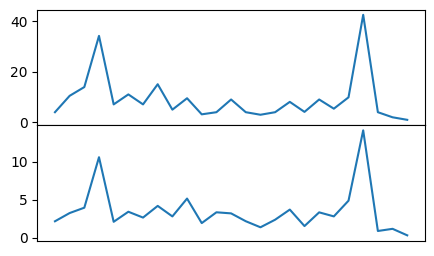

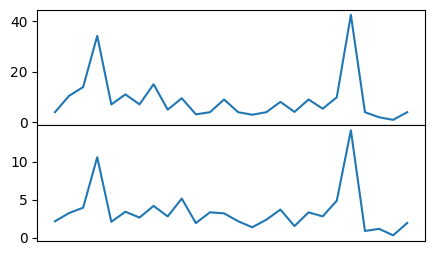

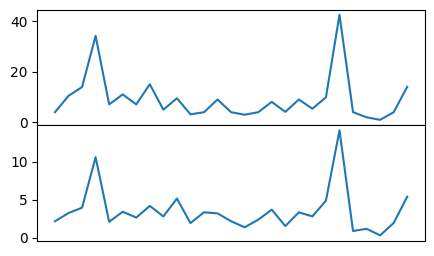

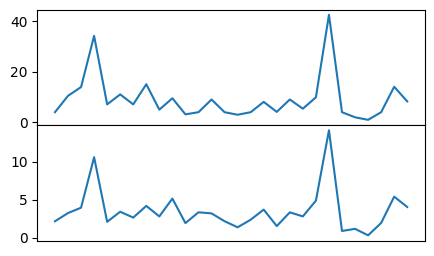

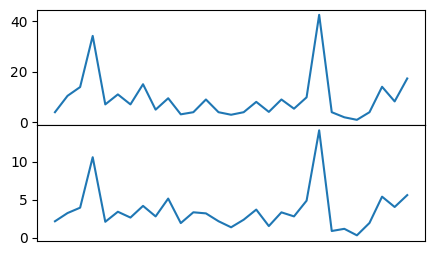

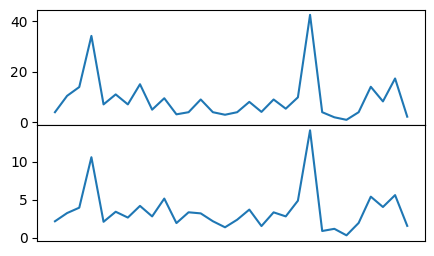

In [1]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
import sys
sys.path.append('../pytorch-openpose/')
from posedet import model
from posedet import util
from posedet.body import Body
from posedet.hand import Hand
from collections import deque

body_estimation = Body('../models/pose/body_pose_model.pth','cpu')
#hand_estimation = Hand('../models/pose/hand_pose_model.pth')

print(f"Torch device: {torch.cuda.get_device_name()}")
video = '/home/irfan/Desktop/Data/CCTV_Exp/Lock/How to break a door cylinder lock in 10 second.mp4'
cap   = cv2.VideoCapture(video)
#cap.set(cv2.CAP_PROP_FPS,10)
#cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)
#cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

class OptFlow():
    def __init__(self,flow_type='sparse',qlen=125):
        # params for ShiTomasi corner detection
        self.feature_params = dict( maxCorners = 100,
                               qualityLevel = 0.3,
                               minDistance = 7,
                               blockSize = 7 )

        # Parameters for lucas kanade optical flow
        self.lk_params = dict( winSize  = (15,15),
                          maxLevel = 2,
                          criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

        # Create some random colors
        self.color      = np.random.randint(0,255,(100,3))
        self.prev_frame = 0
        self.flow_type  = flow_type
        self.dists      = deque(maxlen=qlen)
        
    def get_flow(self,frame):
        if type(self.prev_frame)==type(0):
            self.prev_gray   = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            self.p0          = cv2.goodFeaturesToTrack(self.prev_gray, mask = None, **self.feature_params)
            self.prev_frame  = frame.copy()
            return frame,self.dists
        
        gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if self.flow_type=='dense':
            hsv        = np.zeros_like(frame)
            hsv[...,1] = 255
            flow       = cv2.calcOpticalFlowFarneback(self.prev_gray,gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            flow_img   = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
            
            
        if self.flow_type=='sparse':
            #import pdb;pdb.set_trace()
            mask        = np.zeros_like(frame)
            p1, st, err = cv2.calcOpticalFlowPyrLK(self.prev_gray, gray, self.p0, None, **self.lk_params)
            
            # Select good points
            good_new = p1[st==1]
            good_old = self.p0[st==1]

            # draw the tracks
            dists=[]
            for i,(new,old) in enumerate(zip(good_new,good_old)):
                a,b   = new.ravel().astype('int8')
                c,d   = old.ravel().astype('int8')
                dists+= [np.sqrt((a-c)**2+(b-d)**2)]
                mask  = cv2.line(mask, (a,b),(c,d), self.color[i].tolist(), 2)
                frame = cv2.circle(frame,(a,b),5, self.color[i].tolist(),-1)
            flow_img  = cv2.add(frame,mask)        
            self.p0         = good_new.reshape(-1,1,2)
            self.dists.append([np.max(dists),np.mean(dists)])
        # Now update the previous frame and previous points
        self.prev_gray  = gray.copy()
        self.prev_frame = frame
        return flow_img,np.array(self.dists)
            
flow = OptFlow(flow_type='sparse')
while True:
    frame=0.0; count=3
    for _ in range(count):
        ret, oriImg = cap.read()
        if not ret: break
        #h_ofs,w_ofs = 480//4,640//4
        oriImg = cv2.resize(oriImg,(320,240))
        frame += oriImg#[h_ofs:-h_ofs,w_ofs:-w_ofs]
    frame /= count
    oriImg = np.uint8(frame)
    canvas,dists = flow.get_flow(oriImg)
    
    '''
    candidate, subset = body_estimation(oriImg)
    canvas = copy.deepcopy(oriImg)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    '''
    '''
    # detect hand
    hands_list = util.handDetect(candidate, subset, oriImg)

    all_hand_peaks = []
    for x, y, w, is_left in hands_list:
        peaks = hand_estimation(oriImg[y:y+w, x:x+w, :])
        peaks[:, 0] = np.where(peaks[:, 0]==0, peaks[:, 0], peaks[:, 0]+x)
        peaks[:, 1] = np.where(peaks[:, 1]==0, peaks[:, 1], peaks[:, 1]+y)
        all_hand_peaks.append(peaks)
   
    canvas = util.draw_handpose(canvas, all_hand_peaks)
    '''
    if len(dists)>5:
        fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(5,3))
        plt.subplots_adjust(hspace=0.0)
        axes[0].plot(dists[:,0])
        axes[0].get_xaxis().set_ticks([])
        
        axes[1].plot(dists[:,1])
        axes[1].get_xaxis().set_ticks([])
        plt.show()
        data = np.array(fig.canvas.renderer.buffer_rgba())
        cv2.imshow('data',data)
        #if dists[-1,0]>30:
        #    cv2.imshow(f'data_{dists[-1,0]}',canvas)
        
    cv2.imshow('demo', canvas)#一个窗口用以显示原视频
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [1]:
data.shape

NameError: name 'data' is not defined

In [5]:
axes[i].get_xaxis().set_visible('off')

In [3]:
plt.subplot_adjust(vspace=0.0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot_adjust'

In [10]:
data = np.frombuffer(fig.canvas.print_to_buffer(), dtype=np.uint8)
data

TypeError: a bytes-like object is required, not 'tuple'

In [23]:
from io import BytesIO
io_buffer = BytesIO()
#fig.canvas.print_jpg(io_buffer)
fig.canvas.draw()
data = np.array(fig.canvas.renderer.buffer_rgba())

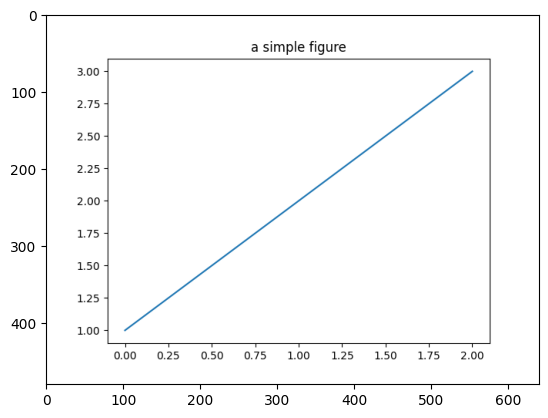

In [24]:
plt.imshow(data)

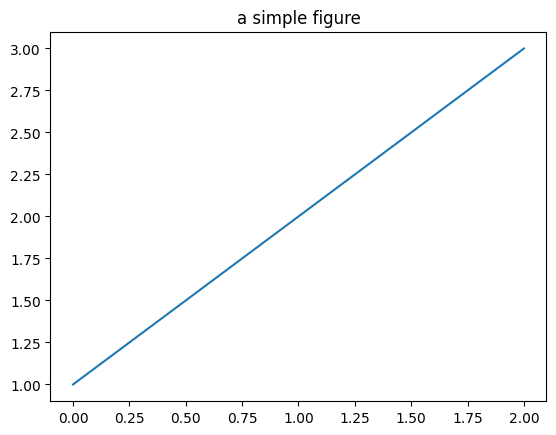

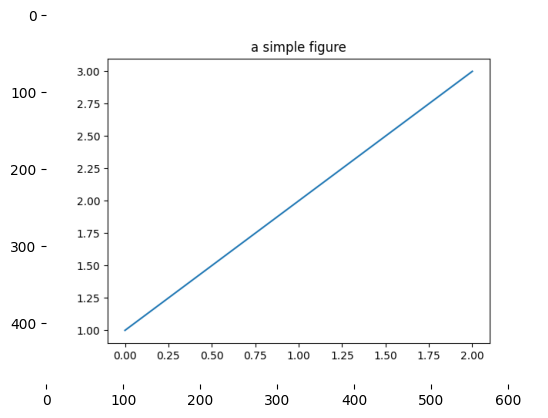

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# make an agg figure
fig, ax = plt.subplots()
ax.plot([1, 2, 3])
ax.set_title('a simple figure')
fig.canvas.draw()

# grab the pixel buffer and dump it into a numpy array
X = np.array(fig.canvas.renderer.buffer_rgba())

# now display the array X as an Axes in a new figure
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, frameon=False)
ax2.imshow(X)
plt.show()

In [4]:
type(np.array([1,1,1]))

numpy.ndarray

In [3]:
oriImg

(120.0, 160.0)

(240, 320, 3)

In [6]:
#plt.imshow(np.uint8(oriImg))
oriImg.max()

255.0

In [1]:
import sys
sys.path.append('../pytorch-openpose/')
from posedet.model import bodypose_model
from posedet.util import transfer

In [2]:
import torch
model   = bodypose_model()
wts     = transfer(model, torch.load('../models/pose/body_pose_model.pth'))
model.load_state_dict(wts)
model.cpu()
model.eval()

bodypose_model(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=

In [3]:
#x = torch.randn(1, 3, 224, 224, requires_grad=True)
#a,b = model(x)
#a.shape,b.shape
#from matplotlib import pyplot as plt
#for i in range
#plt.imshow(b[0,0,:,:].detach().numpy())

In [4]:
import torch
batch_size = 1
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True).half()
model = model.half().to('cpu')#.half()
torch_out = model(x.to('cpu'))
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "../models/pose/body_pose_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

RuntimeError: "slow_conv2d_cpu" not implemented for 'Half'

In [5]:
model

bodypose_model(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=

In [9]:
import torch
torch.nn.Conv(1,10,3).Half()

AttributeError: module 'torch.nn' has no attribute 'Conv'

In [12]:
getattr(torch.nn, 'Conv')

AttributeError: module 'torch.nn' has no attribute 'Conv'

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("_ucf101_bninception__rgb_model_best.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
y = torch.randn(batch_size, 9, 224, 224, requires_grad=True)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(y)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [3]:
model = bodypose_model()

In [ ]:
for i in range(18):
    for n in range(len(subset)):
        index = int(subset[n][i])
        if index == -1:
            continue
        x, y = candidate[index][0:2]
        cv2.circle(canvas, (int(x), int(y)), 4, colors[i], thickness=-1)

In [23]:
subset, np.array(limbSeq[0]) - 1

(array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
          5.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,  6.        ,
          7.        ,  8.        ,  9.        , 10.92186428, 10.        ]]),
 array([1, 2]))

In [22]:
index = subset[0][np.array(limbSeq[0]) - 1]
index

array([1., 2.])

In [17]:
# draw the body keypoint and lims
def draw_bodypose(canvas, candidate, subset):
    stickwidth = 4
    limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
               [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
               [1, 16], [16, 18], [3, 17], [6, 18]]

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    for i in range(18):
        for n in range(len(subset)):
            index = int(subset[n][i])
            if index == -1:
                continue
            x, y = candidate[index][0:2]
            cv2.circle(canvas, (int(x), int(y)), 4, colors[i], thickness=-1)
    '''
    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i]) - 1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    # plt.imsave("preview.jpg", canvas[:, :, [2, 1, 0]])
    # plt.imshow(canvas[:, :, [2, 1, 0]])
    '''
    return canvas


In [18]:
canvas1 = copy.deepcopy(oriImg)
canvas1 = draw_bodypose(canvas1, candidate, subset)

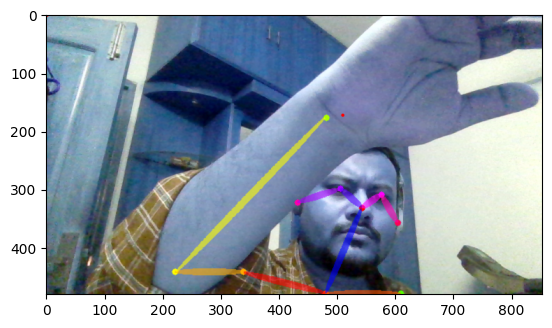

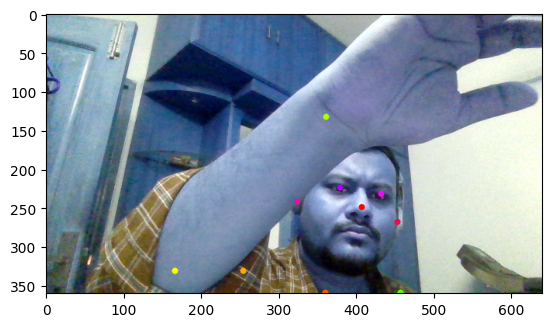

In [19]:
plt.imshow(canvas)
plt.show()
plt.imshow(canvas1)
plt.show()

In [6]:
candidate.shape,subset.shape

((10, 4), (1, 20))

In [3]:
all_hand_peaks

[array([[382, 129],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0]])]

In [ ]:
for peaks in all_hand_peaks:
        for ie, e in enumerate(edges):
            if np.sum(np.all(peaks[e], axis=1)==0)==0:
                x1, y1 = peaks[e[0]]
                x2, y2 = peaks[e[1]]
                ax.plot([x1, x2], [y1, y2], color=matplotlib.colors.hsv_to_rgb([ie/float(len(edges)), 1.0, 1.0]))

        for i, keyponit in enumerate(peaks):
            x, y = keyponit
            ax.plot(x, y, 'r.')
            if show_number:
                ax.text(x, y, str(i))
    bg.draw()
    canvas = np.fromstring(bg.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
